# task 3: Quanvolutional Neural Network

## Theory

### Classical convolution

The convolutional neural network (CNN) is a standard model in classical machine learning, usually used for processing images. It is based on the idea of a convolution layer where, instead of processing the full input data with a global function, each point of the input data is processed locally.

If the input is an image, small local regions are sequentially processed with the same kernel. The results obtained for each region usually are associated to different channels of a single output pixel. The union of all the output pixels produce the new image.

### Quantum convolution

Te same classical idea could be extended for quantum variational circuits.

1. A small region of a input image is embebbed into a quantum circuit. This is done with parametrized rotations applied to the qubits initialized in the ground state.
2. A quantum computation $U$ is performed. The unitary could be generated by a variational quantum circuit or by a random circuit.
3. The quantum system is measured, obtaining a list of classical expectation values. The results could also be post-processed.
4. Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.
5. The same procedure is iterated over the different regions, so as to scan the full input image, producing an output object which is structure as a multichannel object.
6. The quantum convolution can be followed by further quantum layers or by classical layers.

The main difference with its classical counterpart is that a quantum circuit can generate highly complex kernels with computations that, at principle, could be classically intractable.

It will be followed the approach of [1], where a fixed non-trainable quantum circuit is used as a "quanvolution" kernel, while the subsequent classical layers are trained for classification.

## General setup

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Setting the main hyper-parameters of the model

In [2]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30

SAVE_PATH = "./"
PREPROCESS = True # if False it skips the quantum processing and load data fron the SAVE_PATG
USE_MNIST = True # if True, MNIST dataset will be used. If False, Fashion-MNIST dataset will be used.
np.random.seed(0)
tf.random.set_seed(0)

### Loading the MNIST dataset

The focus of this tutorial is on the MNIST dataset. The goal is, given some handrawings of digits from 0 to 9, to classify them to their correspoding digit. Sayed in other way, recognize which digit was tried to be handwrited. While this is a great problem to try on a quanvolutional neural network, we proposed another dataset to be tried:

$\textbf{Fashion-MNIST}$ [2]: Instead of having handwritten numbers, we have different types of clothes (trousers, dresses, shirts, etc). The idea is to classify each clothe in its corresponding type.

Use the USE_MNIST variable to decide which dataset to use. By default, the MNIST dataset is chosen.

In [3]:
if USE_MNIST:
    dataset = keras.datasets.mnist
else:
    dataset = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

# reduce the dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# add extra dimension for convolution channels
train_images = np.array(train_images[... , tf.newaxis],requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## Quantum circuit as convolution kernel

We initialize a default.qubit device, simulating a system of 4 qubits. Its qnode represents a quantum circuit formed by:

1. an embedding layer of local $RY$ rotations (with angles scaled by a factor of $\pi$).
2. a random circuit of $n$ layers.
3. a final measurement in the computational basis, estimating 4 expectation values.

In [5]:
dev = qml.device("default.qubit",wires=4)
# random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # encoding 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j],wires=j)

    # random quantum circuit
    RandomLayers(rand_params,wires=list(range(4)))

    # measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The convolution scheme is defined as follows:

1. the image is divided into squares of $2x2$ pixels.
2. each square is processed by the quantum circuit.
3. the 4 expectation values are mapped into 4 different channels of a single output pixel.

In [6]:
def quanv(image):
    '''
    Convolves the input image using many applications of a quantum circuit
    '''
    out = np.zeros((14, 14, 4))
    
    # loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0,28,2):
        for k in range(0,28,2):
            # process a region fo 2X2 of the image
            q_result = circuit(
                [
                    image[j,k,0],
                    image[j,k+1,0],
                    image[j+1,k,0],
                    image[j+1,k+1,0]
                ]
            )
            # assign expectation values to differents channels of the output pixel (j/2,k/2)
            for c in range(4):
                out[j//2,k//2,c] = q_result[c]
    return out

### Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a pre-processing layer to all the images of the dataset. Then, a classical model will be directly trained and tested over the pre-processed data, so as to avoid unnecesary repetitions of quantum computings.

The pre-processed images will be saved in SAVE_PATH.

In [7]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")

    # preprocess over the train images
    for idx , img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    # preprocess over the test images
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # save the preprocess images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Let's see the effect of the quantum convolution layer on a batch of samples...

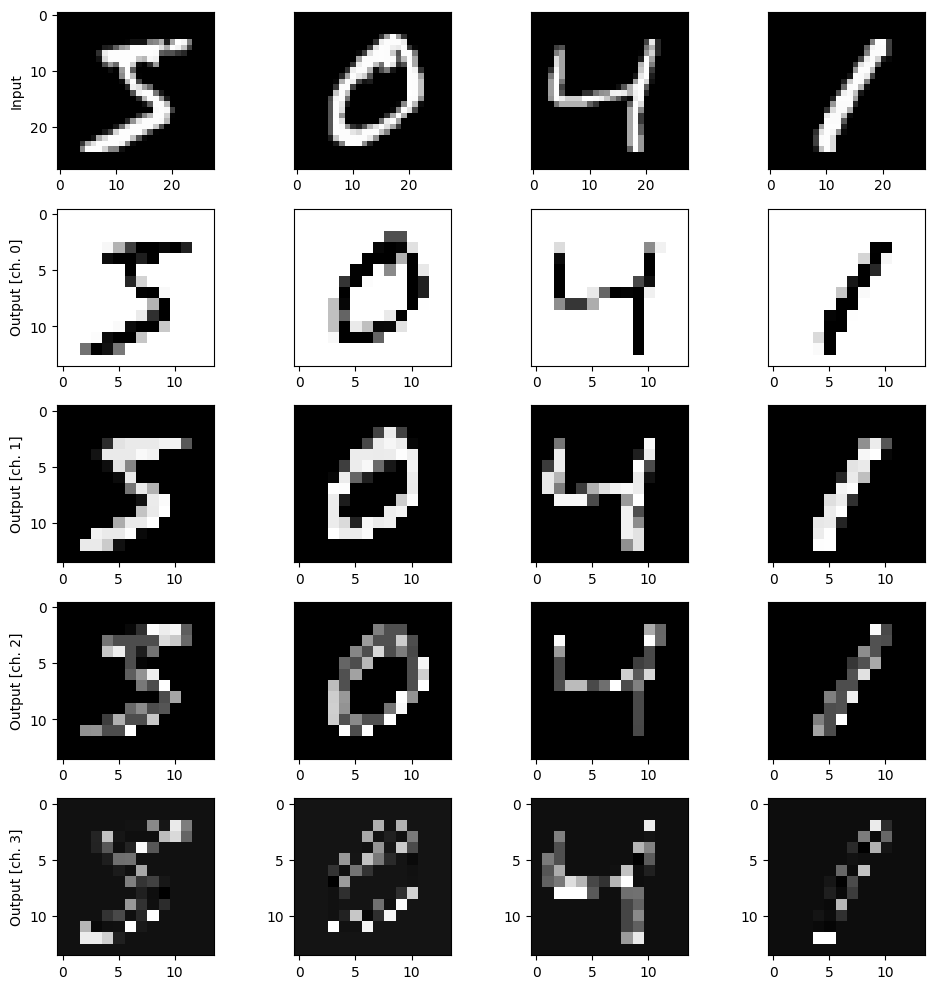

In [8]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

It can be seen each input image and the corresponding output images of the 4 channels. These are generated by the quantum convolution. While the global shape of the images preserved, it could be seen some local distortion, an expected behaviour expected from the quantum kernel.

## Hybrid quantum-classical model

After applying the quantum convolution layers, the resulting features are feed to a classical neural network, so as to train it and classify the different numbers of the dataset.

The model is a fully connected layer with 10 output nodes, ending with a softmax activation function. The chosen optimizer is the $\textit{stochastic-gradient-descent}$ with a loss function $\textit{cross-entropy}$.

In [9]:
def Model():
    '''
    initializes and returns a custom Keras model
    '''
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10,activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Training

We initialize an instance of the model, to train it and validate it with the quantum pre-processed dataset.

In [10]:
q_model = Model()

q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images,test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2
    )

Epoch 1/30
13/13 - 1s - 67ms/step - accuracy: 0.0600 - loss: 2.6982 - val_accuracy: 0.1000 - val_loss: 2.3327
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3000 - loss: 2.0561 - val_accuracy: 0.1333 - val_loss: 2.1150
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.4600 - loss: 1.7027 - val_accuracy: 0.3000 - val_loss: 1.9360
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.6800 - loss: 1.3894 - val_accuracy: 0.4333 - val_loss: 1.7723
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8200 - loss: 1.1529 - val_accuracy: 0.5333 - val_loss: 1.6479
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.8800 - loss: 0.9552 - val_accuracy: 0.6333 - val_loss: 1.5505
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.8035 - val_accuracy: 0.6667 - val_loss: 1.4667
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.6813 - val_accuracy: 0.7000 - val_loss: 1.3981
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9600 - loss: 0.5828 - val_accuracy: 0.7000 - val_loss: 1.3422
Epoch 10/30
13/13 

We will compare the results achieved when using the quantum convolution layer against this other model, which will be trained and validated with the raw MNIST images (that means, without quantum pre-processing). 

In [11]:
c_model = Model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images,test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/30
13/13 - 1s - 52ms/step - accuracy: 0.1400 - loss: 2.3658 - val_accuracy: 0.0667 - val_loss: 2.2534
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.4000 - loss: 1.9525 - val_accuracy: 0.1667 - val_loss: 2.1083
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.6000 - loss: 1.6641 - val_accuracy: 0.3000 - val_loss: 1.9771
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7600 - loss: 1.4278 - val_accuracy: 0.3667 - val_loss: 1.8551
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8000 - loss: 1.2301 - val_accuracy: 0.4667 - val_loss: 1.7466
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.8800 - loss: 1.0652 - val_accuracy: 0.5333 - val_loss: 1.6545
Epoch 7/30
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.9280 - val_accuracy: 0.5333 - val_loss: 1.5781
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9800 - loss: 0.8137 - val_accuracy: 0.5333 - val_loss: 1.5146
Epoch 9/30
13/13 - 0s - 8ms/step - accuracy: 0.9800 - loss: 0.7179 - val_accuracy: 0.5333 - val_loss: 1.4614
Epoch 10/30
13/13 

### Results

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## References

1. Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.
2. https://keras.io/api/datasets/fashion_mnist/
3. https://keras.io/api/datasets/cifar100/